<a href="https://colab.research.google.com/github/a6iyyu/MachineLearning_3F_23/blob/main/JS6/P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praktikum 1**

### **Percobaan 1**

Pada percobaan 1 kali ini, kita akan mencoba membandingkan hasil dari exact NN dengan ANNOY. data yang kita buat adalah data random 2D, dengan 1000 _data point_, mencari 3 data terdekat dari _query point_, Metric Similarity menggunakan Euclidean, dengan 3 tree Annoy.

Instalasi Annoy dulu untuk langkah awal.

In [1]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 16.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551631 sha256=d5c7c40779ce5e126f3999fecb900f3992180af36ff35dbdf3facc81d5caea91
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


Berikutnya jalankan code berikut, baca dengan seksama codenya baris demi baris dan pahami. lakukan beberapa kali percobaan dan perhatikan juga hasilnya. catat hasilnya jika menggunakan jumlah tree yang berbeda.

Exact NN index: [219 898 593]
Exact NN jarak: [0.         1.36915938 2.27931544]
Waktu Exact: 0.2189 ms

Annoy NN index: [219, 898, 593]
Annoy NN jarak: [np.float64(0.0), np.float64(1.369159376273702), np.float64(2.2793154441691197)]
Waktu Annoy: 0.0639 ms


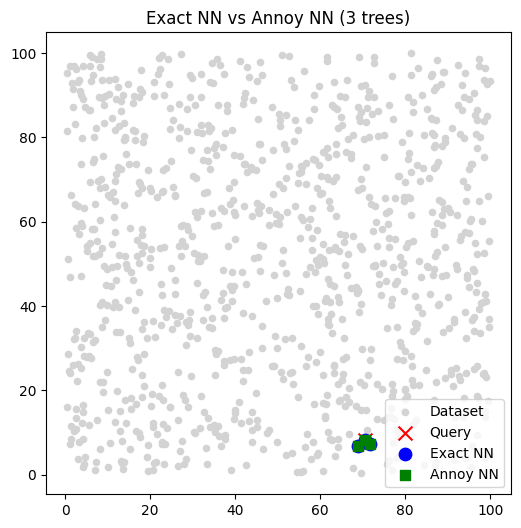

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

# 1. Dataset 2D
np.random.seed(42)
n_points = 1000
X = np.random.rand(n_points, 2) * 100  # titik random dalam ruang 100x100

# Query point (ambil salah satu titik random)
query = X[np.random.randint(0, n_points)]

# 2. Exact NN (brute force)
start = time.time()
distances = np.linalg.norm(X - query, axis=1)
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak:", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

# 3. Annoy NN (3 tree)
f = 2  # dimensi
t = AnnoyIndex(f, 'euclidean')
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # cari 3 NN
time_ann = time.time() - start

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak:", [np.linalg.norm(X[i]-query) for i in idx_ann])
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")

# 4. Visualisasi hasil
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees)")
plt.show()

Pada kode dan tabel berikut percobaan simulasi membuat track rekomendasi spotify dilakukan dengan 20 fitur dan berisi 1 juta lagu (fyi, spotify memiliki 150 jutaan track), isikan hasilnya.

In [3]:
import numpy as np
import time
from sklearn.metrics.pairwise import euclidean_distances
from annoy import AnnoyIndex

# ---- 1. Buat dataset mirip Spotify ----
n_tracks = 50_000_000   # 50 juta track
n_features = 20        # contoh: danceability, energy, tempo, dll.

# dataset besar (random untuk simulasi)
X = np.random.rand(n_tracks, n_features).astype(np.float32)

# query track (misalnya lagu baru)
query = np.random.rand(1, n_features).astype(np.float32)

# ---- 2. Exact NN (brute force) ----
start = time.time()
distances = euclidean_distances(query, X)[0]   # hitung semua jarak
exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
exact_time = time.time() - start

print("Exact NN result:", exact_idx)
print("Exact NN time:", round(exact_time, 3), "seconds")

Exact NN result: [14707690 36415358 14558236 18844295  4303178]
Exact NN time: 4.81 seconds


In [4]:
# ---- 3. Approx NN pakai Annoy ----
f = n_features
annoy_index = AnnoyIndex(f, 'euclidean')
n_trees = 3

# build index
for i in range(n_tracks):
    annoy_index.add_item(i, X[i])
annoy_index.build(n_trees)

True

In [5]:
start = time.time()
annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
annoy_time = time.time() - start

print("Annoy result:", annoy_idx)
print("Annoy time:", round(annoy_time, 3), "seconds")

Annoy result: [761523, 13810934, 49774624, 1097474, 20218093]
Annoy time: 0.0 seconds


**Pertanyaannya:** Kenapa code dibagian build index tidak dihitung waktunya?

**Jawaban:** Waktu untuk membangun indeks `(build())` tidak dihitung karena itu adalah proses "offline" atau persiapan yang hanya dilakukan sesekali. Perbandingan yang adil adalah membandingkan kecepatan pencarian data ("online"), yaitu saat pengguna benar-benar meminta rekomendasi.